# PREPARED BY
## Antara Bhide
## Anastasiia Saenko

The explanation for the CODE is below

In [195]:
'''
PREPARED BY
Antara Bhide
Anastasiia Saenko
'''
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd ### we are only using pandas for model vizualization not actual code



nltk.download('brown')
from nltk.corpus import brown


tagged_sentences = brown.tagged_sents(tagset='universal')[:10000]


test_sentences = brown.tagged_sents(tagset='universal')[10150:10153]


vocabulary = set()
for sentence in tagged_sentences:
    for word, _ in sentence:
        vocabulary.add(word)
vocabulary.add('UNK')


word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

tags = set(tag for _, tag in brown.tagged_words(tagset='universal'))
tag_to_index = {tag: idx for idx, tag in enumerate(tags)}
index_to_tag = {idx: tag for tag, idx in tag_to_index.items()}


num_states = len(tags)
num_observations = len(vocabulary)


transition_matrix = np.ones((num_states, num_states))
for sentence in tagged_sentences:
    tags = [tag for _, tag in sentence]
    for i in range(len(tags) - 1):
        from_state = tag_to_index[tags[i]]
        to_state = tag_to_index[tags[i + 1]]
        transition_matrix[from_state, to_state] += 1


transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)


observation_matrix = np.ones((num_states, num_observations))
for sentence in tagged_sentences:
    for word, tag in sentence:
        tag_index = tag_to_index[tag]
        word_index = word_to_index.get(word, word_to_index['UNK'])
        observation_matrix[tag_index, word_index] += 1


observation_matrix /= np.sum(observation_matrix, axis=1, keepdims=True)


initial_state_distribution = np.ones(num_states)

starts = {}
for sentence in tagged_sentences:
    start_tag = sentence[0][1]
    start_tag_index = tag_to_index[start_tag]
    initial_state_distribution[start_tag_index] += 1
    if start_tag_index not in starts:
      starts[start_tag_index] = start_tag

initial_state_distribution /= np.sum(initial_state_distribution)



num_unique_tags = len(tag_to_index)

#pi = np.ones(num_unique_tags)


initial_state_distribution /= np.sum(initial_state_distribution)
pi = initial_state_distribution


def viterbi(obs, pi, A, B):

    log_d = [np.log(pi) + np.log(B[:, obs[0]])]
    log_psi = [np.zeros((num_states,))]


    for z in obs[1:]:
        log_da = np.expand_dims(log_d[-1], axis=1) + np.log(A)
        log_d.append(np.max(log_da, axis=0) + np.log(B[:, z]))
        log_psi.append(np.argmax(log_da, axis=0))


    log_ps = np.max(log_d[-1])
    qs = [-1] * len(obs)
    qs[-1] = int(np.argmax(log_d[-1]))
    for i in range(len(obs) - 2, -1, -1):
        qs[i] = log_psi[i + 1][qs[i + 1]]

    return qs, np.exp(log_ps)

sentences = []
tags = []
for sentence in test_sentences:
    words = [word for word, _ in sentence]
    observations = [word_to_index.get(word, word_to_index['UNK']) for word in words]


    predicted_tags, _ = viterbi(observations, pi, transition_matrix, observation_matrix)


    # mapping matrix
    sentences += [[word for word, _ in sentence]]
    tags += [[index_to_tag[idx] for idx in predicted_tags]]


    print("Sentence:", " ".join(words))
    print("Predicted Tags:", [index_to_tag[idx] for idx in predicted_tags])
    print()



[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Sentence: Those coming from other denominations will welcome the opportunity to become informed .
Predicted Tags: ['DET', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'VERB', 'VERB', 'DET', 'NOUN', 'PRT', 'VERB', 'VERB', '.']

Sentence: The preparatory class is an introductory face-to-face group in which new members become acquainted with one another .
Predicted Tags: ['DET', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'NUM', 'NOUN', '.']

Sentence: It provides a natural transition into the life of the local church and its organizations .
Predicted Tags: ['PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'CONJ', 'DET', 'NOUN', '.']



In [191]:
print (pi)

[0.24011187 0.19636436 0.06502197 0.11336396 0.00059928 0.01737915
 0.04105074 0.03076308 0.0422493  0.07750699 0.05493408 0.12065521]


# **Tagger Evaluation for Test Sentences**

In [192]:
## creating similar tuple to test_sentences
tuple_sentences = []
for i in range(len(sentences)):
    k = [(word, tag) for word, tag in zip(sentences[i], tags[i])]
    tuple_sentences.append(k)


In [193]:
# test sentences making distinct lists
import pandas as pd
df = pd.DataFrame()
max_length = max(len(s) for s in sentences)
for i in range(len(sentences)):
    col_name = f'Sentence{i+1}'
    col_data = sentences[i] + [None] * (max_length - len(sentences[i]))
    df[col_name] = col_data

max_length = max(len(s) for s in tags)
for i in range(len(tags)):
    col_name = f'tags{i+1}'
    col_data = tags[i] + [None] * (max_length - len(tags[i]))
    df[col_name] = col_data

test_list = []
for i in range(len(test_sentences)):
  test_list += [[k[1] for k in test_sentences[i]]]

max_length = max(len(s) for s in test_list)
for i in range(len(tags)):
    col_name = f'Real_Tag{i+1}'
    col_data = test_list[i] + [None] * (max_length - len(test_list[i]))
    df[col_name] = col_data

# add normal order to the dataframe

df = df[['Sentence1','tags1','Real_Tag1','Sentence2','tags2','Real_Tag2','Sentence3','tags3','Real_Tag3']]


# POS Tagger confusion matrix for each test sentence

Success rate for Sentence 1 is 0.9230769230769231
  Sentence1 tags1 Real_Tag1
1    coming  NOUN      VERB


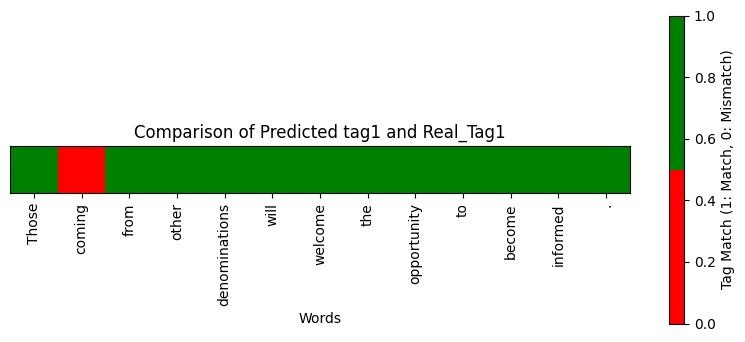


  -------------------------------------------------------------------                   
        
Success rate for Sentence 2 is 0.8888888888888888
       Sentence2 tags2 Real_Tag2
6   face-to-face  NOUN       ADJ
16       another  NOUN       DET


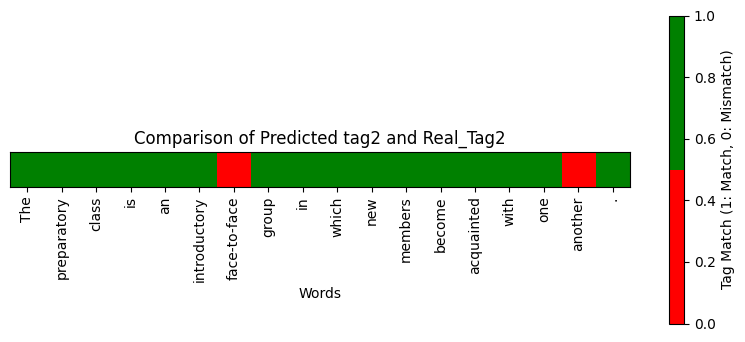


  -------------------------------------------------------------------                   
        
Success rate for Sentence 3 is 1.0
Empty DataFrame
Columns: [Sentence3, tags3, Real_Tag3]
Index: []


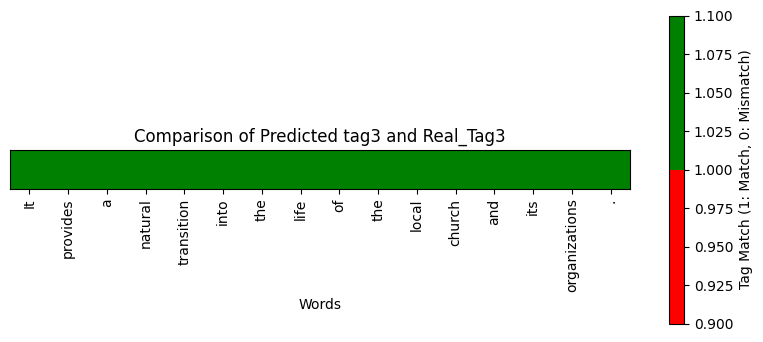


  -------------------------------------------------------------------                   
        
Overall success rate 0.9361702127659575


In [194]:
# @title
#
from matplotlib.colors import ListedColormap
rate = []
for i in range(3):
  cond1 = df[[f'Sentence{i+1}',f'tags{i+1}',f'Real_Tag{i+1}']]
  cond1 = cond1.dropna()
  t = (cond1[f'tags{i+1}'] == cond1[f'Real_Tag{i+1}'])
  tag_matrix = t.astype(int).values.reshape(1, -1)

  print(f'Success rate for Sentence {i+1} is {np.mean(t)}')
  print(cond1[~t])
  t = t.tolist()
  rate += t
  plt.figure(figsize=(10, 4))
  cmap = ListedColormap(['red', 'green'])
  plt.imshow(tag_matrix, cmap=cmap)
  plt.xticks(range(len(cond1)), cond1[f'Sentence{i+1}'], rotation=90)
  plt.yticks([])
  plt.title(f'Comparison of Predicted tag{i+1} and Real_Tag{i+1}')
  plt.xlabel('Words')
  plt.colorbar(label='Tag Match (1: Match, 0: Mismatch)')
  plt.show()
  print('''
  -------------------------------------------------------------------
        ''')

print('Overall success rate', np.mean(rate))

## Explanation for predicted vs actual values.

We got a relatively successful model

1. For the Sentence #1 the success rate is 0.92
2. For the Sentence #2 the success rate is 0.88
3. For the Sentence #3 the sucess rate is 1.

The overall sucess rate for the test set is : 0.94

We plotted confusion arrays for each sentence.

Here are the mistakes we got.

1. Sentence #1. "Coming" was mislabeled as NOUN when it is VERB. The word before the "coming" is "those" we theorize that the most likely POS tags after "those" would be nouns rather  then "coming" --> so it's actually a rare sentence. The model predicted wrong POS accordingly to the real logic of the language since those two POS are not likely to appear together.

2. Sentence #2. face-to-face was read by a model as NOUN token. In a true tagging, it is tagged as NOUN where our model tagged it as an adjective. Face-to-face is most likely an UNK token or OOV token. By the logic of our model the unknown tokens will be predicted as NOUNS since those are the most likely tokens overall.

3. Sentence #2. "Another" was tagged as Noun by our model, while the true tagging is it's DET. "Another" in the Sentence #3 came after "One". We can expect that after NUMBER it's usually a NOUN which is why our model predicted it. So the problem most likely is with the transition matrix, which will give a higher estimate to the NOUN after a NUMBER rather than DET.